<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/1%EC%A3%BC%EC%B0%A8/speech_command_classification_with_torchaudio_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Speech Command Classification with torchaudio

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
[torchaudio](https://github.com/pytorch/audio)_ that can be installed
by following the instructions on the website.


In [3]:
print(torch.__version__)
!python -V

2.1.0+cu118
Python 3.10.12


스트리밍 출력 내용이 길어서 > /dev/null 2>&1을 사용하여 출력 값을 숨김

In [4]:
#파이썬 버전 변경 3.10.12 -> 3.8.6
#ERROR: Could not find a version that satisfies the requirement torch==1.7.0+cpu (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2)
#ERROR: No matching distribution found for torch==1.7.0+cpu 해결
!wget https://www.python.org/ftp/python/3.8.6/Python-3.8.6.tgz > /dev/null 2>&1
!tar xvfz Python-3.8.6.tgz > /dev/null 2>&1
!Python-3.8.6/configure > /dev/null 2>&1
!make > /dev/null 2>&1
!sudo make install > /dev/null 2>&1


In [5]:
#ERROR: command errored out with exit status 1 python setup.py egg_info 해결
!pip install --upgrade setuptools

     |████████████████████████████████| 819 kB 1.3 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 49.2.1
    Uninstalling setuptools-49.2.1:
      Successfully uninstalled setuptools-49.2.1


In [6]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
     |████████████████████████████████| 735.3 MB 20 kB/s 
     |████████████████████████████████| 12.8 MB 5.2 MB/s 
     |████████████████████████████████| 7.6 MB 1.7 MB/s 
     |████████████████████████████████| 17.3 MB 62 kB/s 
     |████████████████████████████████| 840 kB 3.1 MB/s 
     |████████████████████████████████| 3.5 MB 2.1 MB/s 
Using legacy 'setup.py install' for future, since package 'wheel' is not installed.
    Running setup.py install for future ... done


Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209)_, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [8]:
# SpeechCommands 데이터세트 가져오기
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

100%|██████████| 2.26G/2.26G [00:24<00:00, 97.8MB/s]


A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


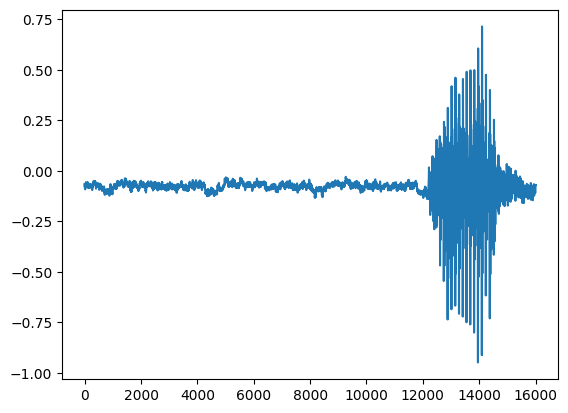

In [9]:
#웨이브폼 (waveform):시간에 따른 오디오 신호의 변화를 표현하는 시각적인 그래픽
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [10]:
import pandas as pd

# 주어진 라벨 리스트
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))

# 데이터 프레임으로 변환
labels_df = pd.DataFrame({'Labels': labels})

# 데이터 프레임 출력
print(labels_df)


      Labels
0   backward
1        bed
2       bird
3        cat
4        dog
5       down
6      eight
7       five
8     follow
9    forward
10      four
11        go
12     happy
13     house
14     learn
15      left
16    marvin
17      nine
18        no
19       off
20        on
21       one
22     right
23     seven
24    sheila
25       six
26      stop
27     three
28      tree
29       two
30        up
31    visual
32       wow
33       yes
34      zero


The 35 audio labels are commands that are said by users. The first few
files are people saying “backward”.




In [11]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “zero”.




In [12]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

## Formatting the Data(전처리)

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [13]:
#transform 객체를 사용하여 데이터를 새로운 샘플 속도로 다시 샘플링함
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

We are encoding each word using its index in the list of labels.




In [14]:
#레이블 목록의 인덱스를 사용하여 각 단어를 인코딩
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see [the
documentation](https://pytorch.org/docs/stable/data.html#working-with-collate-fn)_
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [15]:
#리샘플링과 텍스트 인코딩
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Define the Network

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in [this paper](https://arxiv.org/pdf/1610.00087.pdf)_. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [16]:
#M5 네트워크 아키텍처 모델
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [17]:
# Adam 최적화
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

## Training and Testing the Network

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [18]:
#train 함수가 각 에포크에서의 훈련 손실의 평균을 반환하도록 변수
def train(model, epoch, log_interval):
    model.train()
    total_loss = 0  # 훈련 중 누적된 손실을 추적하기 위한 변수

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        data = transform(data)
        output = model(data)

        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        pbar.update(pbar_update)
        losses.append(loss.item())

    # 훈련 중 누적된 손실의 평균을 반환
    return total_loss / len(train_loader)



Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [19]:
#테스트 기능: 네트워크 정확도를 테스트하기 위한 기능
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




  0%|          | 0.0026666666666666666/2 [00:08<1:48:51, 3269.99s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.772120


  3%|▎         | 0.05599999999999999/2 [00:25<10:26, 322.23s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.269004


  5%|▌         | 0.10933333333333328/2 [00:42<10:03, 319.23s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.717819


  8%|▊         | 0.16266666666666676/2 [00:59<09:40, 316.04s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.253547


 11%|█         | 0.21600000000000033/2 [01:16<09:41, 326.07s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.048482


 13%|█▎        | 0.2693333333333337/2 [01:33<09:11, 318.62s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.998345


 16%|█▌        | 0.3226666666666667/2 [01:49<08:53, 318.10s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.909203


 19%|█▉        | 0.3759999999999997/2 [02:06<08:45, 323.70s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.749094


 21%|██▏       | 0.42933333333333273/2 [02:23<08:21, 319.20s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.640182


 24%|██▍       | 0.48266666666666574/2 [02:40<08:08, 321.88s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.662261


 27%|██▋       | 0.5359999999999995/2 [02:57<07:46, 318.55s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.470715


 29%|██▉       | 0.5893333333333336/2 [03:14<07:21, 313.04s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.384359


 32%|███▏      | 0.6426666666666677/2 [03:30<07:06, 313.87s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.449847


 35%|███▍      | 0.6960000000000018/2 [03:47<06:49, 314.08s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.203965


 37%|███▋      | 0.749333333333336/2 [04:04<06:34, 315.33s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.390738


 40%|████      | 0.8026666666666701/2 [04:20<06:10, 309.67s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.269941


 43%|████▎     | 0.8560000000000042/2 [04:37<05:57, 312.87s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.150370


 50%|█████     | 1.0000000000000062/2 [05:22<05:16, 316.72s/it]


Test Epoch: 1	Accuracy: 6831/11005 (62%)



 50%|█████     | 1.0026666666666728/2 [05:23<05:16, 317.57s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.959713


 53%|█████▎    | 1.0560000000000047/2 [05:39<05:03, 321.66s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.060561


 55%|█████▌    | 1.1093333333333366/2 [05:56<04:40, 314.59s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 0.997714


 58%|█████▊    | 1.1626666666666685/2 [06:13<04:22, 313.14s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.025527


 61%|██████    | 1.2160000000000004/2 [06:29<04:03, 310.36s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 1.057607


 63%|██████▎   | 1.2693333333333323/2 [06:46<03:44, 307.20s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.179126


 66%|██████▌   | 1.3226666666666642/2 [07:02<03:32, 313.51s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 0.995981


 69%|██████▉   | 1.3759999999999961/2 [07:19<03:17, 316.66s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 1.001066


 71%|███████▏  | 1.429333333333328/2 [07:36<02:58, 312.19s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 0.937476


 74%|███████▍  | 1.48266666666666/2 [07:53<02:39, 308.12s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 0.816189


 77%|███████▋  | 1.5359999999999918/2 [08:09<02:23, 309.47s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 0.989004


 79%|███████▉  | 1.5893333333333237/2 [08:26<02:09, 316.04s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 1.053219


 82%|████████▏ | 1.6426666666666556/2 [08:43<01:52, 314.16s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 0.816089


 85%|████████▍ | 1.6959999999999875/2 [09:00<01:33, 306.34s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.855492


 87%|████████▋ | 1.7493333333333194/2 [09:16<01:18, 311.82s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.928128


 90%|█████████ | 1.8026666666666513/2 [09:33<01:01, 311.13s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.755065


 93%|█████████▎| 1.8559999999999832/2 [09:50<00:45, 314.61s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.955578


100%|█████████▉| 1.9999999999999793/2 [10:34<00:00, 317.28s/it]



Test Epoch: 2	Accuracy: 7960/11005 (72%)



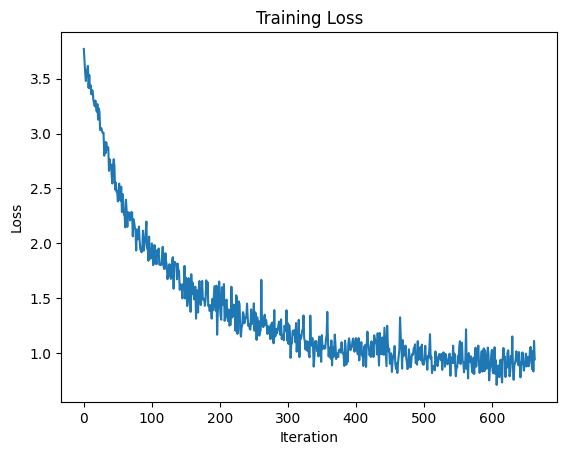

In [ ]:
#2에포크일 경우
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iterations.
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()  # Display the plot


# **데이터 분석 및 모델 성능 평가**(2epoch)

  0%|          | 0.0026666666666666666/21 [00:10<22:24:29, 3841.88s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.964045


  0%|          | 0.05599999999999999/21 [00:31<2:14:45, 386.07s/it]

Train Epoch: 1 [5120/84843 (6%)]	Loss: 3.018462


  1%|          | 0.10933333333333328/21 [00:54<2:26:39, 421.20s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 2.555838


  1%|          | 0.16266666666666676/21 [01:16<2:31:39, 436.69s/it]

Train Epoch: 1 [15360/84843 (18%)]	Loss: 2.320318


  1%|          | 0.21600000000000033/21 [01:40<2:13:48, 386.27s/it]

Train Epoch: 1 [20480/84843 (24%)]	Loss: 1.978151


  1%|▏         | 0.2693333333333337/21 [02:03<2:24:26, 418.04s/it] 

Train Epoch: 1 [25600/84843 (30%)]	Loss: 1.916739


  2%|▏         | 0.3226666666666667/21 [02:24<2:23:55, 417.64s/it] 

Train Epoch: 1 [30720/84843 (36%)]	Loss: 1.788517


  2%|▏         | 0.3759999999999997/21 [02:47<2:12:24, 385.22s/it]

Train Epoch: 1 [35840/84843 (42%)]	Loss: 1.543355


  2%|▏         | 0.42933333333333273/21 [03:09<2:44:40, 480.34s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 1.611007


  2%|▏         | 0.48266666666666574/21 [03:30<2:09:41, 379.25s/it]

Train Epoch: 1 [46080/84843 (54%)]	Loss: 1.466490


  3%|▎         | 0.5359999999999995/21 [03:52<2:24:23, 423.35s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 1.492673


  3%|▎         | 0.5893333333333336/21 [04:13<2:07:01, 373.42s/it]

Train Epoch: 1 [56320/84843 (66%)]	Loss: 1.359081


  3%|▎         | 0.6426666666666677/21 [04:37<2:11:58, 388.97s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 1.297126


  3%|▎         | 0.6960000000000018/21 [05:00<2:40:39, 474.74s/it]

Train Epoch: 1 [66560/84843 (78%)]	Loss: 1.128222


  4%|▎         | 0.749333333333336/21 [05:21<2:09:01, 382.27s/it] 

Train Epoch: 1 [71680/84843 (84%)]	Loss: 1.137279


  4%|▍         | 0.8026666666666701/21 [05:44<2:20:56, 418.68s/it]

Train Epoch: 1 [76800/84843 (90%)]	Loss: 1.139043


  4%|▍         | 0.8560000000000042/21 [06:06<2:31:24, 450.95s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 1.149032


  5%|▍         | 1.0000000000000062/21 [07:04<2:45:51, 497.56s/it]


Test Epoch: 1	Accuracy: 5812/11005 (53%)



  5%|▍         | 1.0026666666666728/21 [07:04<2:26:18, 438.97s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 1.204174


  5%|▌         | 1.0560000000000047/21 [07:23<1:44:46, 315.23s/it]

Train Epoch: 2 [5120/84843 (6%)]	Loss: 1.206458


  5%|▌         | 1.1093333333333366/21 [07:42<2:10:28, 393.57s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 1.068241


  6%|▌         | 1.1626666666666685/21 [08:01<1:58:59, 359.88s/it]

Train Epoch: 2 [15360/84843 (18%)]	Loss: 1.028789


  6%|▌         | 1.2160000000000004/21 [08:19<1:43:56, 315.23s/it]

Train Epoch: 2 [20480/84843 (24%)]	Loss: 0.976142


  6%|▌         | 1.2693333333333323/21 [08:38<1:46:13, 323.02s/it]

Train Epoch: 2 [25600/84843 (30%)]	Loss: 1.091564


  6%|▋         | 1.3226666666666642/21 [08:57<2:03:51, 377.66s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 1.063859


  7%|▋         | 1.3759999999999961/21 [09:16<1:53:28, 346.97s/it]

Train Epoch: 2 [35840/84843 (42%)]	Loss: 1.051939


  7%|▋         | 1.429333333333328/21 [09:34<1:45:47, 324.32s/it] 

Train Epoch: 2 [40960/84843 (48%)]	Loss: 1.032398


  7%|▋         | 1.48266666666666/21 [09:54<2:08:17, 394.41s/it]  

Train Epoch: 2 [46080/84843 (54%)]	Loss: 1.140620


  7%|▋         | 1.5359999999999918/21 [10:12<1:44:55, 323.42s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 1.165905


  8%|▊         | 1.5893333333333237/21 [10:29<1:40:37, 311.04s/it]

Train Epoch: 2 [56320/84843 (66%)]	Loss: 0.960172


  8%|▊         | 1.6426666666666556/21 [10:49<2:19:13, 431.52s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 1.021340


  8%|▊         | 1.6959999999999875/21 [11:07<1:46:13, 330.18s/it]

Train Epoch: 2 [66560/84843 (78%)]	Loss: 0.791543


  8%|▊         | 1.7493333333333194/21 [11:25<1:38:41, 307.58s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 0.792531


  9%|▊         | 1.8026666666666513/21 [11:43<2:03:35, 386.26s/it]

Train Epoch: 2 [76800/84843 (90%)]	Loss: 0.780556


  9%|▉         | 1.8559999999999832/21 [12:03<1:48:57, 341.47s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 0.869700


 10%|▉         | 1.9999999999999793/21 [12:51<1:37:08, 306.77s/it]


Test Epoch: 2	Accuracy: 7355/11005 (67%)



 10%|▉         | 2.002666666666646/21 [12:52<1:37:00, 306.37s/it] 

Train Epoch: 3 [0/84843 (0%)]	Loss: 0.942542


 10%|▉         | 2.0559999999999823/21 [13:11<2:03:13, 390.27s/it]

Train Epoch: 3 [5120/84843 (6%)]	Loss: 0.798216


 10%|█         | 2.1093333333333186/21 [13:30<1:41:52, 323.59s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 0.831369


 10%|█         | 2.162666666666655/21 [13:48<1:36:23, 307.01s/it]

Train Epoch: 3 [15360/84843 (18%)]	Loss: 0.763949


 11%|█         | 2.2159999999999913/21 [14:08<1:55:43, 369.63s/it]

Train Epoch: 3 [20480/84843 (24%)]	Loss: 0.808522


 11%|█         | 2.2693333333333277/21 [14:27<1:52:33, 360.58s/it]

Train Epoch: 3 [25600/84843 (30%)]	Loss: 0.696966


 11%|█         | 2.322666666666664/21 [14:45<1:38:08, 315.27s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 0.933905


 11%|█▏        | 2.3760000000000003/21 [15:03<1:36:23, 310.54s/it]

Train Epoch: 3 [35840/84843 (42%)]	Loss: 0.838213


 12%|█▏        | 2.4293333333333367/21 [15:22<2:00:31, 389.38s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 0.841622


 12%|█▏        | 2.482666666666673/21 [15:40<1:38:03, 317.72s/it]

Train Epoch: 3 [46080/84843 (54%)]	Loss: 0.771145


 12%|█▏        | 2.5360000000000094/21 [15:58<1:34:50, 308.20s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 0.738500


 12%|█▏        | 2.5893333333333457/21 [16:17<2:13:44, 435.89s/it]

Train Epoch: 3 [56320/84843 (66%)]	Loss: 0.840317


 13%|█▎        | 2.642666666666682/21 [16:35<1:41:42, 332.43s/it] 

Train Epoch: 3 [61440/84843 (72%)]	Loss: 0.850857


 13%|█▎        | 2.6960000000000184/21 [16:53<1:34:35, 310.07s/it]

Train Epoch: 3 [66560/84843 (78%)]	Loss: 0.678254


 13%|█▎        | 2.7493333333333547/21 [17:12<1:56:31, 383.09s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 0.663946


 13%|█▎        | 2.802666666666691/21 [17:31<1:45:56, 349.30s/it] 

Train Epoch: 3 [76800/84843 (90%)]	Loss: 0.753834


 14%|█▎        | 2.8560000000000274/21 [17:48<1:34:19, 311.92s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 0.730055


 14%|█▍        | 3.0000000000000355/21 [18:38<2:08:08, 427.17s/it]


Test Epoch: 3	Accuracy: 8167/11005 (74%)



 14%|█▍        | 3.0026666666667023/21 [18:39<2:04:34, 415.29s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 0.713181


 15%|█▍        | 3.0560000000000387/21 [18:57<1:37:51, 327.24s/it]

Train Epoch: 4 [5120/84843 (6%)]	Loss: 0.743781


 15%|█▍        | 3.109333333333375/21 [19:15<1:37:11, 325.96s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 0.762418


 15%|█▌        | 3.1626666666667114/21 [19:34<2:04:56, 420.29s/it]

Train Epoch: 4 [15360/84843 (18%)]	Loss: 0.693682


 15%|█▌        | 3.2160000000000477/21 [19:52<1:39:49, 336.80s/it]

Train Epoch: 4 [20480/84843 (24%)]	Loss: 0.703454


 16%|█▌        | 3.269333333333384/21 [20:11<2:05:41, 425.33s/it] 

Train Epoch: 4 [25600/84843 (30%)]	Loss: 0.704310


 16%|█▌        | 3.3226666666667204/21 [20:31<2:05:58, 427.56s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 0.679641


 16%|█▌        | 3.3760000000000567/21 [20:49<1:35:53, 326.47s/it]

Train Epoch: 4 [35840/84843 (42%)]	Loss: 0.590469


 16%|█▋        | 3.429333333333393/21 [21:07<1:31:40, 313.05s/it] 

Train Epoch: 4 [40960/84843 (48%)]	Loss: 0.671723


 17%|█▋        | 3.4826666666667294/21 [21:26<1:54:48, 393.22s/it]

Train Epoch: 4 [46080/84843 (54%)]	Loss: 0.625172


 17%|█▋        | 3.5360000000000658/21 [21:44<1:40:10, 344.19s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 0.593404


 17%|█▋        | 3.589333333333402/21 [22:02<1:30:02, 310.32s/it] 

Train Epoch: 4 [56320/84843 (66%)]	Loss: 0.698231


 17%|█▋        | 3.6426666666667384/21 [22:20<1:28:00, 304.23s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 0.771448


 18%|█▊        | 3.696000000000075/21 [22:39<1:51:01, 384.95s/it]

Train Epoch: 4 [66560/84843 (78%)]	Loss: 0.999777


 18%|█▊        | 3.749333333333411/21 [22:57<1:32:30, 321.75s/it] 

Train Epoch: 4 [71680/84843 (84%)]	Loss: 0.611807


 18%|█▊        | 3.8026666666667475/21 [23:15<1:28:14, 307.89s/it]

Train Epoch: 4 [76800/84843 (90%)]	Loss: 0.687014


 18%|█▊        | 3.856000000000084/21 [23:34<2:02:15, 427.87s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 0.620173


 19%|█▉        | 4.0000000000000915/21 [24:22<1:29:49, 317.01s/it]


Test Epoch: 4	Accuracy: 8434/11005 (77%)



 19%|█▉        | 4.002666666666758/21 [24:23<1:28:31, 312.49s/it] 

Train Epoch: 5 [0/84843 (0%)]	Loss: 0.556402


 19%|█▉        | 4.056000000000085/21 [24:41<1:27:53, 311.25s/it]

Train Epoch: 5 [5120/84843 (6%)]	Loss: 0.762063


 20%|█▉        | 4.109333333333413/21 [25:01<1:45:36, 375.15s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 0.452419


 20%|█▉        | 4.16266666666674/21 [25:19<1:28:43, 316.16s/it] 

Train Epoch: 5 [15360/84843 (18%)]	Loss: 0.695791


 20%|██        | 4.216000000000068/21 [25:37<1:26:23, 308.81s/it]

Train Epoch: 5 [20480/84843 (24%)]	Loss: 0.577913


 20%|██        | 4.269333333333395/21 [25:56<2:00:49, 433.29s/it]

Train Epoch: 5 [25600/84843 (30%)]	Loss: 0.694834


 21%|██        | 4.322666666666723/21 [26:14<1:30:58, 327.30s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 0.703444


 21%|██        | 4.37600000000005/21 [26:32<1:24:59, 306.73s/it] 

Train Epoch: 5 [35840/84843 (42%)]	Loss: 0.785950


 21%|██        | 4.4293333333333775/21 [26:52<1:42:37, 371.62s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 0.689023


 21%|██▏       | 4.482666666666705/21 [27:11<1:37:51, 355.45s/it]

Train Epoch: 5 [46080/84843 (54%)]	Loss: 0.627173


 22%|██▏       | 4.5360000000000325/21 [27:29<1:25:36, 312.01s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 0.651472


 22%|██▏       | 4.58933333333336/21 [27:46<1:23:11, 304.16s/it]  

Train Epoch: 5 [56320/84843 (66%)]	Loss: 0.728068


 22%|██▏       | 4.642666666666687/21 [28:06<1:46:00, 388.84s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 0.813535


 22%|██▏       | 4.696000000000015/21 [28:24<1:26:50, 319.56s/it] 

Train Epoch: 5 [66560/84843 (78%)]	Loss: 0.828325


 23%|██▎       | 4.749333333333342/21 [28:42<1:23:38, 308.82s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 0.624635


 23%|██▎       | 4.80266666666667/21 [29:01<1:57:24, 434.94s/it] 

Train Epoch: 5 [76800/84843 (90%)]	Loss: 0.596448


 23%|██▎       | 4.855999999999997/21 [29:19<1:28:13, 327.92s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 0.715306


 24%|██▍       | 4.999999999999981/21 [30:07<1:21:10, 304.41s/it]


Test Epoch: 5	Accuracy: 8567/11005 (78%)



 24%|██▍       | 5.002666666666648/21 [30:09<1:30:27, 339.28s/it]

Train Epoch: 6 [0/84843 (0%)]	Loss: 0.636985


 24%|██▍       | 5.055999999999975/21 [30:28<1:36:31, 363.23s/it]

Train Epoch: 6 [5120/84843 (6%)]	Loss: 0.732392


 24%|██▍       | 5.109333333333303/21 [30:46<1:26:31, 326.72s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 0.730008


 25%|██▍       | 5.16266666666663/21 [31:04<1:22:54, 314.08s/it] 

Train Epoch: 6 [15360/84843 (18%)]	Loss: 0.549506


 25%|██▍       | 5.215999999999958/21 [31:24<1:44:48, 398.38s/it]

Train Epoch: 6 [20480/84843 (24%)]	Loss: 0.584028


 25%|██▌       | 5.269333333333285/21 [31:42<1:24:13, 321.25s/it]

Train Epoch: 6 [25600/84843 (30%)]	Loss: 0.752089


 25%|██▌       | 5.3226666666666125/21 [32:00<1:20:11, 306.91s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 0.666036


 26%|██▌       | 5.37599999999994/21 [32:20<1:52:13, 430.95s/it] 

Train Epoch: 6 [35840/84843 (42%)]	Loss: 0.542908


 26%|██▌       | 5.429333333333267/21 [32:37<1:25:16, 328.61s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 0.486273


 26%|██▌       | 5.482666666666595/21 [32:55<1:20:25, 310.97s/it] 

Train Epoch: 6 [46080/84843 (54%)]	Loss: 0.573231


 26%|██▋       | 5.535999999999922/21 [33:16<1:50:24, 428.39s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 0.645683


 27%|██▋       | 5.58933333333325/21 [33:34<1:23:51, 326.51s/it] 

Train Epoch: 6 [56320/84843 (66%)]	Loss: 0.724792


 27%|██▋       | 5.642666666666577/21 [33:52<1:18:56, 308.42s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 0.511752


 27%|██▋       | 5.695999999999905/21 [34:11<1:41:54, 399.56s/it]

Train Epoch: 6 [66560/84843 (78%)]	Loss: 0.659425


 27%|██▋       | 5.749333333333232/21 [34:29<1:27:46, 345.31s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 0.482668


 28%|██▊       | 5.80266666666656/21 [34:47<1:18:16, 309.03s/it] 

Train Epoch: 6 [76800/84843 (90%)]	Loss: 0.585604


 28%|██▊       | 5.855999999999887/21 [35:05<1:22:29, 326.83s/it]

Train Epoch: 6 [81920/84843 (96%)]	Loss: 0.681336


 29%|██▊       | 5.999999999999871/21 [35:55<1:22:39, 330.64s/it]


Test Epoch: 6	Accuracy: 8473/11005 (77%)



 29%|██▊       | 6.002666666666538/21 [35:55<1:20:58, 323.96s/it]

Train Epoch: 7 [0/84843 (0%)]	Loss: 0.516549


 29%|██▉       | 6.055999999999865/21 [36:13<1:16:20, 306.48s/it]

Train Epoch: 7 [5120/84843 (6%)]	Loss: 0.560230


 29%|██▉       | 6.1093333333331925/21 [36:32<1:41:42, 409.85s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 0.565612


 29%|██▉       | 6.16266666666652/21 [36:50<1:23:28, 337.54s/it] 

Train Epoch: 7 [15360/84843 (18%)]	Loss: 0.658834


 30%|██▉       | 6.215999999999847/21 [37:08<1:16:43, 311.36s/it]

Train Epoch: 7 [20480/84843 (24%)]	Loss: 0.565274


 30%|██▉       | 6.269333333333175/21 [37:26<1:20:18, 327.10s/it] 

Train Epoch: 7 [25600/84843 (30%)]	Loss: 0.617769


 30%|███       | 6.322666666666502/21 [37:45<1:29:22, 365.36s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 0.637696


 30%|███       | 6.37599999999983/21 [38:03<1:17:47, 319.17s/it] 

Train Epoch: 7 [35840/84843 (42%)]	Loss: 0.550321


 31%|███       | 6.429333333333157/21 [38:21<1:14:48, 308.06s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 0.686260


 31%|███       | 6.482666666666485/21 [38:41<1:38:23, 406.64s/it]

Train Epoch: 7 [46080/84843 (54%)]	Loss: 0.633858


 31%|███       | 6.535999999999812/21 [38:58<1:18:32, 325.81s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 0.663119


 31%|███▏      | 6.58933333333314/21 [39:16<1:14:31, 310.26s/it] 

Train Epoch: 7 [56320/84843 (66%)]	Loss: 0.582851


 32%|███▏      | 6.642666666666467/21 [39:35<1:43:11, 431.22s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 0.486737


 32%|███▏      | 6.695999999999795/21 [39:56<1:16:40, 321.65s/it]

Train Epoch: 7 [66560/84843 (78%)]	Loss: 0.605418


 32%|███▏      | 6.749333333333122/21 [40:14<1:13:53, 311.09s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 0.531625


 32%|███▏      | 6.8026666666664495/21 [40:33<1:41:47, 430.16s/it]

Train Epoch: 7 [76800/84843 (90%)]	Loss: 0.723087


 33%|███▎      | 6.855999999999777/21 [40:51<1:17:17, 327.87s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 0.582145


 33%|███▎      | 6.999999999999761/21 [41:39<1:10:51, 303.67s/it]


Test Epoch: 7	Accuracy: 8577/11005 (78%)



 33%|███▎      | 7.0026666666664275/21 [41:40<1:17:22, 331.64s/it]

Train Epoch: 8 [0/84843 (0%)]	Loss: 0.533168


 34%|███▎      | 7.055999999999755/21 [41:59<1:25:35, 368.27s/it] 

Train Epoch: 8 [5120/84843 (6%)]	Loss: 0.589986


 34%|███▍      | 7.109333333333082/21 [42:17<1:13:11, 316.13s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 0.568713


 34%|███▍      | 7.16266666666641/21 [42:34<1:10:44, 306.73s/it]  

Train Epoch: 8 [15360/84843 (18%)]	Loss: 0.465517


 34%|███▍      | 7.215999999999737/21 [42:54<1:38:04, 426.92s/it]

Train Epoch: 8 [20480/84843 (24%)]	Loss: 0.528585


 35%|███▍      | 7.269333333333065/21 [43:12<1:14:16, 324.55s/it]

Train Epoch: 8 [25600/84843 (30%)]	Loss: 0.833380


 35%|███▍      | 7.322666666666392/21 [43:30<1:10:10, 307.82s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 0.603255


 35%|███▌      | 7.37599999999972/21 [43:49<1:35:45, 421.73s/it] 

Train Epoch: 8 [35840/84843 (42%)]	Loss: 0.702016


 35%|███▌      | 7.429333333333047/21 [44:08<1:16:25, 337.88s/it]

Train Epoch: 8 [40960/84843 (48%)]	Loss: 0.607156


 36%|███▌      | 7.482666666666375/21 [44:25<1:09:57, 310.52s/it]

Train Epoch: 8 [46080/84843 (54%)]	Loss: 0.560509


 36%|███▌      | 7.535999999999702/21 [44:43<1:18:08, 348.19s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 0.510671


 36%|███▌      | 7.5893333333330295/21 [45:02<1:20:44, 361.25s/it]

Train Epoch: 8 [56320/84843 (66%)]	Loss: 0.619670


 36%|███▋      | 7.642666666666357/21 [45:20<1:09:59, 314.41s/it]

Train Epoch: 8 [61440/84843 (72%)]	Loss: 0.598606


 37%|███▋      | 7.695999999999684/21 [45:38<1:08:36, 309.46s/it]

Train Epoch: 8 [66560/84843 (78%)]	Loss: 0.504929


 37%|███▋      | 7.749333333333012/21 [45:58<1:28:16, 399.72s/it] 

Train Epoch: 8 [71680/84843 (84%)]	Loss: 0.758300


 37%|███▋      | 7.802666666666339/21 [46:16<1:28:00, 400.12s/it]

Train Epoch: 8 [76800/84843 (90%)]	Loss: 0.612654


 37%|███▋      | 7.855999999999667/21 [46:35<1:07:04, 306.19s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 0.540491


 38%|███▊      | 7.999999999999651/21 [47:25<1:13:18, 338.33s/it]


Test Epoch: 8	Accuracy: 8703/11005 (79%)



 38%|███▊      | 8.002666666666318/21 [47:25<1:11:04, 328.10s/it]

Train Epoch: 9 [0/84843 (0%)]	Loss: 0.514617


 38%|███▊      | 8.055999999999646/21 [47:43<1:06:25, 307.91s/it]

Train Epoch: 9 [5120/84843 (6%)]	Loss: 0.586115


 39%|███▊      | 8.109333333332973/21 [48:02<1:21:04, 377.33s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 0.624763


 39%|███▉      | 8.1626666666663/21 [48:20<1:15:18, 351.99s/it]  

Train Epoch: 9 [15360/84843 (18%)]	Loss: 0.602270


 39%|███▉      | 8.215999999999628/21 [48:38<1:07:32, 316.98s/it]

Train Epoch: 9 [20480/84843 (24%)]	Loss: 0.597790


 39%|███▉      | 8.269333333332956/21 [48:56<1:04:26, 303.72s/it]

Train Epoch: 9 [25600/84843 (30%)]	Loss: 0.689076


 40%|███▉      | 8.322666666666283/21 [49:16<1:21:08, 384.06s/it]

Train Epoch: 9 [30720/84843 (36%)]	Loss: 0.443321


 40%|███▉      | 8.37599999999961/21 [49:33<1:07:19, 319.95s/it] 

Train Epoch: 9 [35840/84843 (42%)]	Loss: 0.576832


 40%|████      | 8.429333333332938/21 [49:51<1:05:13, 311.33s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 0.589552


 40%|████      | 8.482666666666265/21 [50:11<1:28:56, 426.31s/it]

Train Epoch: 9 [46080/84843 (54%)]	Loss: 0.524082


 41%|████      | 8.535999999999593/21 [50:29<1:08:27, 329.51s/it]

Train Epoch: 9 [51200/84843 (60%)]	Loss: 0.552302


 41%|████      | 8.58933333333292/21 [50:46<1:04:10, 310.26s/it] 

Train Epoch: 9 [56320/84843 (66%)]	Loss: 0.715810


 41%|████      | 8.642666666666248/21 [51:05<1:19:42, 387.03s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 0.513917


 41%|████▏     | 8.695999999999575/21 [51:24<1:11:57, 350.89s/it]

Train Epoch: 9 [66560/84843 (78%)]	Loss: 0.560910


 42%|████▏     | 8.749333333332903/21 [51:42<1:03:17, 309.98s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 0.641126


 42%|████▏     | 8.80266666666623/21 [51:59<1:01:50, 304.22s/it] 

Train Epoch: 9 [76800/84843 (90%)]	Loss: 0.643681


 42%|████▏     | 8.855999999999558/21 [52:19<1:19:53, 394.75s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 0.502481


 43%|████▎     | 8.999999999999542/21 [53:06<1:01:10, 305.88s/it]


Test Epoch: 9	Accuracy: 8835/11005 (80%)



 43%|████▎     | 9.002666666666208/21 [53:07<1:01:57, 309.88s/it]

Train Epoch: 10 [0/84843 (0%)]	Loss: 0.514525


 43%|████▎     | 9.055999999999536/21 [53:28<1:24:10, 422.84s/it]

Train Epoch: 10 [5120/84843 (6%)]	Loss: 0.653843


 43%|████▎     | 9.109333333332863/21 [53:46<1:04:03, 323.23s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 0.563883


 44%|████▎     | 9.16266666666619/21 [54:04<1:01:09, 310.02s/it] 

Train Epoch: 10 [15360/84843 (18%)]	Loss: 0.392592


 44%|████▍     | 9.215999999999518/21 [54:23<1:19:12, 403.32s/it]

Train Epoch: 10 [20480/84843 (24%)]	Loss: 0.565126


 44%|████▍     | 9.269333333332845/21 [54:41<1:06:50, 341.85s/it]

Train Epoch: 10 [25600/84843 (30%)]	Loss: 0.493920


 44%|████▍     | 9.322666666666173/21 [54:59<1:01:32, 316.22s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 0.620670


 45%|████▍     | 9.3759999999995/21 [55:18<1:16:09, 393.13s/it]  

Train Epoch: 10 [35840/84843 (42%)]	Loss: 0.522535


 45%|████▍     | 9.429333333332828/21 [55:37<1:08:26, 354.86s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 0.576093


 45%|████▌     | 9.482666666666155/21 [55:56<1:00:48, 316.75s/it]

Train Epoch: 10 [46080/84843 (54%)]	Loss: 0.564954


 45%|████▌     | 9.535999999999483/21 [56:14<1:01:22, 321.23s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 0.554098


 46%|████▌     | 9.58933333333281/21 [56:33<1:10:33, 371.02s/it] 

Train Epoch: 10 [56320/84843 (66%)]	Loss: 0.578796


 46%|████▌     | 9.642666666666138/21 [56:51<59:45, 315.66s/it]  

Train Epoch: 10 [61440/84843 (72%)]	Loss: 0.581971


 46%|████▌     | 9.695999999999465/21 [57:09<57:53, 307.30s/it]

Train Epoch: 10 [66560/84843 (78%)]	Loss: 0.510345


 46%|████▋     | 9.749333333332793/21 [57:28<1:19:20, 423.16s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 0.506002


 47%|████▋     | 9.80266666666612/21 [57:46<59:57, 321.24s/it]   

Train Epoch: 10 [76800/84843 (90%)]	Loss: 0.640493


 47%|████▋     | 9.855999999999447/21 [58:03<57:12, 308.05s/it]

Train Epoch: 10 [81920/84843 (96%)]	Loss: 0.823527


 48%|████▊     | 9.999999999999432/21 [58:53<1:13:04, 398.55s/it]


Test Epoch: 10	Accuracy: 8839/11005 (80%)



 48%|████▊     | 10.002666666666098/21 [58:54<1:07:47, 369.87s/it]

Train Epoch: 11 [0/84843 (0%)]	Loss: 0.413676


 48%|████▊     | 10.055999999999425/21 [59:12<59:26, 325.93s/it]  

Train Epoch: 11 [5120/84843 (6%)]	Loss: 0.501374


 48%|████▊     | 10.109333333332753/21 [59:29<55:27, 305.51s/it]

Train Epoch: 11 [10240/84843 (12%)]	Loss: 0.533961


 48%|████▊     | 10.16266666666608/21 [59:49<1:15:38, 418.80s/it] 

Train Epoch: 11 [15360/84843 (18%)]	Loss: 0.496623


 49%|████▊     | 10.215999999999408/21 [1:00:07<1:04:26, 358.57s/it]

Train Epoch: 11 [20480/84843 (24%)]	Loss: 0.439036


 49%|████▉     | 10.269333333332735/21 [1:00:26<54:06, 302.58s/it]

Train Epoch: 11 [25600/84843 (30%)]	Loss: 0.535882


 49%|████▉     | 10.322666666666063/21 [1:00:45<1:12:54, 409.74s/it]

Train Epoch: 11 [30720/84843 (36%)]	Loss: 0.476583


 49%|████▉     | 10.37599999999939/21 [1:01:03<57:55, 327.12s/it] 

Train Epoch: 11 [35840/84843 (42%)]	Loss: 0.494404


 50%|████▉     | 10.429333333332718/21 [1:01:21<54:03, 306.80s/it]

Train Epoch: 11 [40960/84843 (48%)]	Loss: 0.560651


 50%|████▉     | 10.482666666666045/21 [1:01:39<1:10:37, 402.94s/it]

Train Epoch: 11 [46080/84843 (54%)]	Loss: 0.566010


 50%|█████     | 10.535999999999373/21 [1:01:58<1:00:05, 344.60s/it]

Train Epoch: 11 [51200/84843 (60%)]	Loss: 0.740774


 50%|█████     | 10.5893333333327/21 [1:02:16<54:13, 312.48s/it]  

Train Epoch: 11 [56320/84843 (66%)]	Loss: 0.567107


 51%|█████     | 10.642666666666027/21 [1:02:34<52:36, 304.79s/it]

Train Epoch: 11 [61440/84843 (72%)]	Loss: 0.491181


 51%|█████     | 10.695999999999355/21 [1:02:53<1:05:46, 383.00s/it]

Train Epoch: 11 [66560/84843 (78%)]	Loss: 0.537831


 51%|█████     | 10.749333333332682/21 [1:03:11<55:04, 322.35s/it]

Train Epoch: 11 [71680/84843 (84%)]	Loss: 0.656376


 51%|█████▏    | 10.80266666666601/21 [1:03:29<52:00, 306.02s/it] 

Train Epoch: 11 [76800/84843 (90%)]	Loss: 0.623696


 52%|█████▏    | 10.855999999999337/21 [1:03:48<1:11:38, 423.74s/it]

Train Epoch: 11 [81920/84843 (96%)]	Loss: 0.533138


 52%|█████▏    | 10.999999999999321/21 [1:04:36<52:53, 317.39s/it]


Test Epoch: 11	Accuracy: 8660/11005 (79%)



 52%|█████▏    | 11.002666666665988/21 [1:04:37<52:19, 314.00s/it]

Train Epoch: 12 [0/84843 (0%)]	Loss: 0.415580


 53%|█████▎    | 11.055999999999315/21 [1:04:55<54:51, 330.97s/it]

Train Epoch: 12 [5120/84843 (6%)]	Loss: 0.577787


 53%|█████▎    | 11.109333333332643/21 [1:05:14<1:01:04, 370.51s/it]

Train Epoch: 12 [10240/84843 (12%)]	Loss: 0.627443


 53%|█████▎    | 11.16266666666597/21 [1:05:32<51:10, 312.16s/it] 

Train Epoch: 12 [15360/84843 (18%)]	Loss: 0.484388


 53%|█████▎    | 11.215999999999298/21 [1:05:50<49:15, 302.11s/it]

Train Epoch: 12 [20480/84843 (24%)]	Loss: 0.650355


 54%|█████▎    | 11.269333333332625/21 [1:06:09<1:09:07, 426.25s/it]

Train Epoch: 12 [25600/84843 (30%)]	Loss: 0.455547


 54%|█████▍    | 11.322666666665953/21 [1:06:27<52:17, 324.26s/it]

Train Epoch: 12 [30720/84843 (36%)]	Loss: 0.496226


 54%|█████▍    | 11.37599999999928/21 [1:06:45<49:41, 309.76s/it] 

Train Epoch: 12 [35840/84843 (42%)]	Loss: 0.451068


 54%|█████▍    | 11.429333333332607/21 [1:07:05<1:15:52, 475.63s/it]

Train Epoch: 12 [40960/84843 (48%)]	Loss: 0.474746


 55%|█████▍    | 11.482666666665935/21 [1:07:24<55:12, 348.08s/it]

Train Epoch: 12 [46080/84843 (54%)]	Loss: 0.535423


 55%|█████▍    | 11.535999999999262/21 [1:07:42<53:37, 339.96s/it]

Train Epoch: 12 [51200/84843 (60%)]	Loss: 0.449089


 55%|█████▌    | 11.58933333333259/21 [1:08:00<51:43, 329.75s/it] 

Train Epoch: 12 [56320/84843 (66%)]	Loss: 0.581794


 55%|█████▌    | 11.642666666665917/21 [1:08:19<57:07, 366.26s/it]  

Train Epoch: 12 [61440/84843 (72%)]	Loss: 0.550426


 56%|█████▌    | 11.695999999999245/21 [1:08:37<50:18, 324.38s/it]

Train Epoch: 12 [66560/84843 (78%)]	Loss: 0.572543


 56%|█████▌    | 11.749333333332572/21 [1:08:55<46:57, 304.58s/it]

Train Epoch: 12 [71680/84843 (84%)]	Loss: 0.492169


 56%|█████▌    | 11.8026666666659/21 [1:09:14<1:03:54, 416.91s/it]  

Train Epoch: 12 [76800/84843 (90%)]	Loss: 0.670613


 56%|█████▋    | 11.855999999999227/21 [1:09:32<49:09, 322.57s/it]

Train Epoch: 12 [81920/84843 (96%)]	Loss: 0.651374


 57%|█████▋    | 11.999999999999211/21 [1:10:20<45:48, 305.40s/it]


Test Epoch: 12	Accuracy: 8907/11005 (81%)



 57%|█████▋    | 12.002666666665878/21 [1:10:21<52:20, 349.01s/it]

Train Epoch: 13 [0/84843 (0%)]	Loss: 0.635969


 57%|█████▋    | 12.055999999999205/21 [1:10:40<54:31, 365.82s/it]

Train Epoch: 13 [5120/84843 (6%)]	Loss: 0.514413


 58%|█████▊    | 12.109333333332533/21 [1:10:58<46:33, 314.16s/it]

Train Epoch: 13 [10240/84843 (12%)]	Loss: 0.494608


 58%|█████▊    | 12.16266666666586/21 [1:11:16<45:27, 308.64s/it] 

Train Epoch: 13 [15360/84843 (18%)]	Loss: 0.484851


 58%|█████▊    | 12.215999999999188/21 [1:11:35<58:08, 397.10s/it]  

Train Epoch: 13 [20480/84843 (24%)]	Loss: 0.373690


 58%|█████▊    | 12.269333333332515/21 [1:11:53<47:35, 327.05s/it]

Train Epoch: 13 [25600/84843 (30%)]	Loss: 0.478569


 59%|█████▊    | 12.322666666665842/21 [1:12:11<44:33, 308.05s/it]

Train Epoch: 13 [30720/84843 (36%)]	Loss: 0.495819


 59%|█████▉    | 12.37599999999917/21 [1:12:31<1:02:50, 437.24s/it]

Train Epoch: 13 [35840/84843 (42%)]	Loss: 0.507875


 59%|█████▉    | 12.429333333332497/21 [1:12:49<47:02, 329.31s/it]

Train Epoch: 13 [40960/84843 (48%)]	Loss: 0.513500


 59%|█████▉    | 12.482666666665825/21 [1:13:07<44:09, 311.06s/it]

Train Epoch: 13 [46080/84843 (54%)]	Loss: 0.691891


 60%|█████▉    | 12.535999999999152/21 [1:13:26<57:37, 408.50s/it]

Train Epoch: 13 [51200/84843 (60%)]	Loss: 0.509813


 60%|█████▉    | 12.58933333333248/21 [1:13:45<50:26, 359.83s/it] 

Train Epoch: 13 [56320/84843 (66%)]	Loss: 0.595334


 60%|██████    | 12.642666666665807/21 [1:14:04<46:24, 333.17s/it]

Train Epoch: 13 [61440/84843 (72%)]	Loss: 0.514918


 60%|██████    | 12.695999999999135/21 [1:14:23<55:48, 403.28s/it]

Train Epoch: 13 [66560/84843 (78%)]	Loss: 0.486179


 61%|██████    | 12.749333333332462/21 [1:14:42<47:22, 344.53s/it]

Train Epoch: 13 [71680/84843 (84%)]	Loss: 0.551336


 61%|██████    | 12.80266666666579/21 [1:15:00<43:03, 315.22s/it] 

Train Epoch: 13 [76800/84843 (90%)]	Loss: 0.674424


 61%|██████    | 12.855999999999117/21 [1:15:18<45:14, 333.35s/it]

Train Epoch: 13 [81920/84843 (96%)]	Loss: 0.532756


 62%|██████▏   | 12.999999999999101/21 [1:16:08<44:24, 333.03s/it]


Test Epoch: 13	Accuracy: 8754/11005 (80%)



 62%|██████▏   | 13.002666666665768/21 [1:16:09<43:38, 327.39s/it]

Train Epoch: 14 [0/84843 (0%)]	Loss: 0.488829


 62%|██████▏   | 13.055999999999095/21 [1:16:27<40:54, 309.03s/it]

Train Epoch: 14 [5120/84843 (6%)]	Loss: 0.624220


 62%|██████▏   | 13.109333333332422/21 [1:16:46<57:02, 433.69s/it]

Train Epoch: 14 [10240/84843 (12%)]	Loss: 0.556836


 63%|██████▎   | 13.16266666666575/21 [1:17:04<43:27, 332.68s/it] 

Train Epoch: 14 [15360/84843 (18%)]	Loss: 0.513601


 63%|██████▎   | 13.215999999999077/21 [1:17:22<40:17, 310.58s/it]

Train Epoch: 14 [20480/84843 (24%)]	Loss: 0.505310


 63%|██████▎   | 13.269333333332405/21 [1:17:41<50:10, 389.38s/it]

Train Epoch: 14 [25600/84843 (30%)]	Loss: 0.586932


 63%|██████▎   | 13.322666666665732/21 [1:18:00<44:42, 349.46s/it]

Train Epoch: 14 [30720/84843 (36%)]	Loss: 0.634951


 64%|██████▎   | 13.37599999999906/21 [1:18:18<39:54, 314.11s/it] 

Train Epoch: 14 [35840/84843 (42%)]	Loss: 0.476295


 64%|██████▍   | 13.429333333332387/21 [1:18:35<38:42, 306.74s/it]

Train Epoch: 14 [40960/84843 (48%)]	Loss: 0.462669


 64%|██████▍   | 13.482666666665715/21 [1:18:55<47:42, 380.80s/it]

Train Epoch: 14 [46080/84843 (54%)]	Loss: 0.471067


 64%|██████▍   | 13.535999999999042/21 [1:19:13<39:41, 319.09s/it]

Train Epoch: 14 [51200/84843 (60%)]	Loss: 0.524645


 65%|██████▍   | 13.58933333333237/21 [1:19:30<37:45, 305.70s/it] 

Train Epoch: 14 [56320/84843 (66%)]	Loss: 0.467547


 65%|██████▍   | 13.642666666665697/21 [1:19:50<52:25, 427.57s/it]

Train Epoch: 14 [61440/84843 (72%)]	Loss: 0.568394


 65%|██████▌   | 13.695999999999025/21 [1:20:08<39:33, 324.90s/it]

Train Epoch: 14 [66560/84843 (78%)]	Loss: 0.672381


 65%|██████▌   | 13.749333333332352/21 [1:20:26<37:13, 308.08s/it]

Train Epoch: 14 [71680/84843 (84%)]	Loss: 0.458500


 66%|██████▌   | 13.80266666666568/21 [1:20:44<47:35, 396.68s/it] 

Train Epoch: 14 [76800/84843 (90%)]	Loss: 0.489071


 66%|██████▌   | 13.855999999999007/21 [1:21:05<43:15, 363.27s/it]

Train Epoch: 14 [81920/84843 (96%)]	Loss: 0.622717


 67%|██████▋   | 13.999999999998991/21 [1:21:53<35:37, 305.38s/it]


Test Epoch: 14	Accuracy: 8759/11005 (80%)



 67%|██████▋   | 14.002666666665657/21 [1:21:54<35:26, 303.92s/it]

Train Epoch: 15 [0/84843 (0%)]	Loss: 0.445063


 67%|██████▋   | 14.055999999998985/21 [1:22:13<48:31, 419.23s/it]

Train Epoch: 15 [5120/84843 (6%)]	Loss: 0.490949


 67%|██████▋   | 14.109333333332312/21 [1:22:31<37:07, 323.25s/it]

Train Epoch: 15 [10240/84843 (12%)]	Loss: 0.540399


 67%|██████▋   | 14.16266666666564/21 [1:22:49<35:03, 307.64s/it] 

Train Epoch: 15 [15360/84843 (18%)]	Loss: 0.513912


 68%|██████▊   | 14.215999999998967/21 [1:23:07<45:49, 405.35s/it]

Train Epoch: 15 [20480/84843 (24%)]	Loss: 0.622517


 68%|██████▊   | 14.269333333332295/21 [1:23:26<38:42, 345.12s/it]

Train Epoch: 15 [25600/84843 (30%)]	Loss: 0.640155


 68%|██████▊   | 14.322666666665622/21 [1:23:44<34:43, 312.03s/it]

Train Epoch: 15 [30720/84843 (36%)]	Loss: 0.415622


 68%|██████▊   | 14.37599999999895/21 [1:24:02<37:11, 336.86s/it] 

Train Epoch: 15 [35840/84843 (42%)]	Loss: 0.458679


 69%|██████▊   | 14.429333333332277/21 [1:24:21<40:10, 366.80s/it]

Train Epoch: 15 [40960/84843 (48%)]	Loss: 0.473760


 69%|██████▉   | 14.482666666665605/21 [1:24:39<34:45, 320.05s/it]

Train Epoch: 15 [46080/84843 (54%)]	Loss: 0.526312


 69%|██████▉   | 14.535999999998932/21 [1:24:57<32:55, 305.57s/it]

Train Epoch: 15 [51200/84843 (60%)]	Loss: 0.443941


 69%|██████▉   | 14.58933333333226/21 [1:25:17<42:18, 395.94s/it] 

Train Epoch: 15 [56320/84843 (66%)]	Loss: 0.531414


 70%|██████▉   | 14.642666666665587/21 [1:25:34<34:06, 321.97s/it]

Train Epoch: 15 [61440/84843 (72%)]	Loss: 0.449330


 70%|██████▉   | 14.695999999998914/21 [1:25:52<32:11, 306.38s/it]

Train Epoch: 15 [66560/84843 (78%)]	Loss: 0.532248


 70%|███████   | 14.749333333332242/21 [1:26:12<43:18, 415.72s/it]

Train Epoch: 15 [71680/84843 (84%)]	Loss: 0.471735


 70%|███████   | 14.80266666666557/21 [1:26:30<34:53, 337.73s/it] 

Train Epoch: 15 [76800/84843 (90%)]	Loss: 0.515215


 71%|███████   | 14.855999999998897/21 [1:26:48<32:02, 312.90s/it]

Train Epoch: 15 [81920/84843 (96%)]	Loss: 0.543198


 71%|███████▏  | 14.999999999998881/21 [1:27:38<40:07, 401.26s/it]


Test Epoch: 15	Accuracy: 8843/11005 (80%)



 71%|███████▏  | 15.002666666665547/21 [1:27:39<37:11, 372.09s/it]

Train Epoch: 16 [0/84843 (0%)]	Loss: 0.382030


 72%|███████▏  | 15.055999999998875/21 [1:27:58<37:27, 378.17s/it]

Train Epoch: 16 [5120/84843 (6%)]	Loss: 0.466903


 72%|███████▏  | 15.109333333332202/21 [1:28:16<34:42, 353.59s/it]

Train Epoch: 16 [10240/84843 (12%)]	Loss: 0.443655


 72%|███████▏  | 15.16266666666553/21 [1:28:35<35:02, 360.23s/it] 

Train Epoch: 16 [15360/84843 (18%)]	Loss: 0.510503


 72%|███████▏  | 15.215999999998857/21 [1:28:53<30:41, 318.30s/it]

Train Epoch: 16 [20480/84843 (24%)]	Loss: 0.390771


 73%|███████▎  | 15.269333333332185/21 [1:29:11<29:24, 307.86s/it]

Train Epoch: 16 [25600/84843 (30%)]	Loss: 0.571407


 73%|███████▎  | 15.322666666665512/21 [1:29:31<37:53, 400.48s/it]

Train Epoch: 16 [30720/84843 (36%)]	Loss: 0.545004


 73%|███████▎  | 15.37599999999884/21 [1:29:48<30:10, 321.94s/it] 

Train Epoch: 16 [35840/84843 (42%)]	Loss: 0.602560


 73%|███████▎  | 15.429333333332167/21 [1:30:06<28:32, 307.35s/it]

Train Epoch: 16 [40960/84843 (48%)]	Loss: 0.444082


 74%|███████▎  | 15.482666666665494/21 [1:30:26<38:48, 422.08s/it]

Train Epoch: 16 [46080/84843 (54%)]	Loss: 0.645892


 74%|███████▍  | 15.535999999998822/21 [1:30:44<30:39, 336.63s/it]

Train Epoch: 16 [51200/84843 (60%)]	Loss: 0.645873


 74%|███████▍  | 15.58933333333215/21 [1:31:02<27:45, 307.76s/it] 

Train Epoch: 16 [56320/84843 (66%)]	Loss: 0.475175


 74%|███████▍  | 15.642666666665477/21 [1:31:20<32:59, 369.58s/it]

Train Epoch: 16 [61440/84843 (72%)]	Loss: 0.598502


 75%|███████▍  | 15.695999999998804/21 [1:31:39<31:26, 355.67s/it]

Train Epoch: 16 [66560/84843 (78%)]	Loss: 0.489385


 75%|███████▍  | 15.749333333332132/21 [1:31:57<28:41, 327.90s/it]

Train Epoch: 16 [71680/84843 (84%)]	Loss: 0.522049


 75%|███████▌  | 15.80266666666546/21 [1:32:15<28:49, 332.74s/it] 

Train Epoch: 16 [76800/84843 (90%)]	Loss: 0.493085


 76%|███████▌  | 15.855999999998787/21 [1:32:35<31:43, 369.97s/it]

Train Epoch: 16 [81920/84843 (96%)]	Loss: 0.560106


 76%|███████▌  | 15.99999999999877/21 [1:33:23<25:36, 307.21s/it] 


Test Epoch: 16	Accuracy: 8834/11005 (80%)



 76%|███████▌  | 16.002666666665437/21 [1:33:23<25:40, 308.23s/it]

Train Epoch: 17 [0/84843 (0%)]	Loss: 0.451554


 76%|███████▋  | 16.055999999998765/21 [1:33:42<33:24, 405.50s/it]

Train Epoch: 17 [5120/84843 (6%)]	Loss: 0.383886


 77%|███████▋  | 16.109333333332092/21 [1:34:01<27:57, 343.01s/it]

Train Epoch: 17 [10240/84843 (12%)]	Loss: 0.496227


 77%|███████▋  | 16.16266666666542/21 [1:34:19<25:13, 312.78s/it] 

Train Epoch: 17 [15360/84843 (18%)]	Loss: 0.361973


 77%|███████▋  | 16.215999999998747/21 [1:34:37<28:02, 351.63s/it]

Train Epoch: 17 [20480/84843 (24%)]	Loss: 0.473532


 77%|███████▋  | 16.269333333332074/21 [1:34:58<26:35, 337.23s/it]

Train Epoch: 17 [25600/84843 (30%)]	Loss: 0.350648


 78%|███████▊  | 16.322666666665402/21 [1:35:15<24:10, 310.10s/it]

Train Epoch: 17 [30720/84843 (36%)]	Loss: 0.521635


 78%|███████▊  | 16.37599999999873/21 [1:35:34<28:12, 366.09s/it] 

Train Epoch: 17 [35840/84843 (42%)]	Loss: 0.513471


 78%|███████▊  | 16.429333333332057/21 [1:35:53<27:06, 355.85s/it]

Train Epoch: 17 [40960/84843 (48%)]	Loss: 0.441370


 78%|███████▊  | 16.482666666665384/21 [1:36:11<23:28, 311.76s/it]

Train Epoch: 17 [46080/84843 (54%)]	Loss: 0.527727


 79%|███████▊  | 16.53599999999871/21 [1:36:28<22:44, 305.65s/it] 

Train Epoch: 17 [51200/84843 (60%)]	Loss: 0.468305


 79%|███████▉  | 16.58933333333204/21 [1:36:48<29:19, 399.02s/it] 

Train Epoch: 17 [56320/84843 (66%)]	Loss: 0.354041


 79%|███████▉  | 16.642666666665367/21 [1:37:06<23:18, 321.06s/it]

Train Epoch: 17 [61440/84843 (72%)]	Loss: 0.668646


 80%|███████▉  | 16.695999999998694/21 [1:37:24<22:08, 308.59s/it]

Train Epoch: 17 [66560/84843 (78%)]	Loss: 0.519642


 80%|███████▉  | 16.74933333333202/21 [1:37:43<30:17, 427.53s/it] 

Train Epoch: 17 [71680/84843 (84%)]	Loss: 0.475420


 80%|████████  | 16.80266666666535/21 [1:38:01<24:34, 351.28s/it] 

Train Epoch: 17 [76800/84843 (90%)]	Loss: 0.479401


 80%|████████  | 16.855999999998676/21 [1:38:19<21:30, 311.53s/it]

Train Epoch: 17 [81920/84843 (96%)]	Loss: 0.607276


 81%|████████  | 16.99999999999866/21 [1:39:09<25:51, 387.93s/it] 


Test Epoch: 17	Accuracy: 8952/11005 (81%)



 81%|████████  | 17.002666666665327/21 [1:39:10<24:18, 364.79s/it]

Train Epoch: 18 [0/84843 (0%)]	Loss: 0.451494


 81%|████████  | 17.055999999998654/21 [1:39:28<20:40, 314.53s/it]

Train Epoch: 18 [5120/84843 (6%)]	Loss: 0.435582


 81%|████████▏ | 17.109333333331982/21 [1:39:45<19:52, 306.57s/it]

Train Epoch: 18 [10240/84843 (12%)]	Loss: 0.497601


 82%|████████▏ | 17.16266666666531/21 [1:40:05<26:09, 408.99s/it] 

Train Epoch: 18 [15360/84843 (18%)]	Loss: 0.453351


 82%|████████▏ | 17.215999999998637/21 [1:40:23<20:19, 322.31s/it]

Train Epoch: 18 [20480/84843 (24%)]	Loss: 0.517080


 82%|████████▏ | 17.269333333331964/21 [1:40:40<19:13, 309.12s/it]

Train Epoch: 18 [25600/84843 (30%)]	Loss: 0.485825


 82%|████████▏ | 17.32266666666529/21 [1:40:59<25:00, 408.00s/it] 

Train Epoch: 18 [30720/84843 (36%)]	Loss: 0.396648


 83%|████████▎ | 17.37599999999862/21 [1:41:18<20:25, 338.13s/it] 

Train Epoch: 18 [35840/84843 (42%)]	Loss: 0.538986


 83%|████████▎ | 17.429333333331947/21 [1:41:36<18:28, 310.48s/it]

Train Epoch: 18 [40960/84843 (48%)]	Loss: 0.667776


 83%|████████▎ | 17.482666666665274/21 [1:41:55<18:03, 307.91s/it]

Train Epoch: 18 [46080/84843 (54%)]	Loss: 0.433832


 84%|████████▎ | 17.5359999999986/21 [1:42:14<24:23, 422.53s/it]  

Train Epoch: 18 [51200/84843 (60%)]	Loss: 0.542718


 84%|████████▍ | 17.58933333333193/21 [1:42:32<18:18, 322.03s/it] 

Train Epoch: 18 [56320/84843 (66%)]	Loss: 0.637362


 84%|████████▍ | 17.642666666665257/21 [1:42:50<17:07, 306.06s/it]

Train Epoch: 18 [61440/84843 (72%)]	Loss: 0.492087


 84%|████████▍ | 17.695999999998584/21 [1:43:08<20:57, 380.53s/it]

Train Epoch: 18 [66560/84843 (78%)]	Loss: 0.465321


 85%|████████▍ | 17.74933333333191/21 [1:43:27<18:42, 345.41s/it] 

Train Epoch: 18 [71680/84843 (84%)]	Loss: 0.557500


 85%|████████▍ | 17.80266666666524/21 [1:43:44<16:30, 309.68s/it] 

Train Epoch: 18 [76800/84843 (90%)]	Loss: 0.457539


 85%|████████▌ | 17.855999999998566/21 [1:44:02<15:59, 305.18s/it]

Train Epoch: 18 [81920/84843 (96%)]	Loss: 0.537143


 86%|████████▌ | 17.99999999999855/21 [1:44:52<16:42, 334.17s/it] 


Test Epoch: 18	Accuracy: 8918/11005 (81%)



 86%|████████▌ | 18.002666666665217/21 [1:44:53<16:13, 324.72s/it]

Train Epoch: 19 [0/84843 (0%)]	Loss: 0.441903


 86%|████████▌ | 18.055999999998544/21 [1:45:10<15:11, 309.73s/it]

Train Epoch: 19 [5120/84843 (6%)]	Loss: 0.404467


 86%|████████▌ | 18.109333333331872/21 [1:45:29<17:43, 367.90s/it]

Train Epoch: 19 [10240/84843 (12%)]	Loss: 0.461962


 86%|████████▋ | 18.1626666666652/21 [1:45:47<16:46, 354.63s/it]  

Train Epoch: 19 [15360/84843 (18%)]	Loss: 0.490263


 87%|████████▋ | 18.215999999998527/21 [1:46:05<14:25, 310.92s/it]

Train Epoch: 19 [20480/84843 (24%)]	Loss: 0.508499


 87%|████████▋ | 18.269333333331854/21 [1:46:23<14:09, 311.14s/it]

Train Epoch: 19 [25600/84843 (30%)]	Loss: 0.494217


 87%|████████▋ | 18.32266666666518/21 [1:46:42<17:40, 396.08s/it] 

Train Epoch: 19 [30720/84843 (36%)]	Loss: 0.479461


 88%|████████▊ | 18.37599999999851/21 [1:47:00<13:54, 318.22s/it] 

Train Epoch: 19 [35840/84843 (42%)]	Loss: 0.472519


 88%|████████▊ | 18.429333333331837/21 [1:47:17<13:01, 303.99s/it]

Train Epoch: 19 [40960/84843 (48%)]	Loss: 0.471224


 88%|████████▊ | 18.482666666665164/21 [1:47:36<16:53, 402.64s/it]

Train Epoch: 19 [46080/84843 (54%)]	Loss: 0.524884


 88%|████████▊ | 18.53599999999849/21 [1:47:54<13:55, 338.94s/it] 

Train Epoch: 19 [51200/84843 (60%)]	Loss: 0.536961


 89%|████████▊ | 18.58933333333182/21 [1:48:12<12:20, 307.20s/it] 

Train Epoch: 19 [56320/84843 (66%)]	Loss: 0.432918


 89%|████████▉ | 18.642666666665146/21 [1:48:31<15:30, 394.66s/it]

Train Epoch: 19 [61440/84843 (72%)]	Loss: 0.553689


 89%|████████▉ | 18.695999999998474/21 [1:48:51<16:05, 419.10s/it]

Train Epoch: 19 [66560/84843 (78%)]	Loss: 0.509207


 89%|████████▉ | 18.7493333333318/21 [1:49:08<12:13, 325.90s/it]  

Train Epoch: 19 [71680/84843 (84%)]	Loss: 0.609793


 90%|████████▉ | 18.80266666666513/21 [1:49:26<11:08, 304.01s/it] 

Train Epoch: 19 [76800/84843 (90%)]	Loss: 0.677631


 90%|████████▉ | 18.855999999998456/21 [1:49:44<13:05, 366.15s/it]

Train Epoch: 19 [81920/84843 (96%)]	Loss: 0.598531


 90%|█████████ | 18.99999999999844/21 [1:50:33<10:53, 326.69s/it] 


Test Epoch: 19	Accuracy: 8873/11005 (81%)



 90%|█████████ | 19.002666666665107/21 [1:50:34<10:38, 319.62s/it]

Train Epoch: 20 [0/84843 (0%)]	Loss: 0.400311


 91%|█████████ | 19.055999999998434/21 [1:50:51<09:50, 303.74s/it]

Train Epoch: 20 [5120/84843 (6%)]	Loss: 0.409682


 91%|█████████ | 19.10933333333176/21 [1:51:10<13:06, 416.22s/it] 

Train Epoch: 20 [10240/84843 (12%)]	Loss: 0.362246


 91%|█████████▏| 19.16266666666509/21 [1:51:28<10:14, 334.23s/it] 

Train Epoch: 20 [15360/84843 (18%)]	Loss: 0.468712


 92%|█████████▏| 19.215999999998417/21 [1:51:46<09:06, 306.07s/it]

Train Epoch: 20 [20480/84843 (24%)]	Loss: 0.426888


 92%|█████████▏| 19.269333333331744/21 [1:52:04<09:35, 332.48s/it]

Train Epoch: 20 [25600/84843 (30%)]	Loss: 0.531854


 92%|█████████▏| 19.32266666666507/21 [1:52:23<10:13, 365.63s/it] 

Train Epoch: 20 [30720/84843 (36%)]	Loss: 0.436421


 92%|█████████▏| 19.3759999999984/21 [1:52:41<08:34, 316.64s/it]  

Train Epoch: 20 [35840/84843 (42%)]	Loss: 0.600373


 93%|█████████▎| 19.429333333331726/21 [1:52:58<07:59, 305.42s/it]

Train Epoch: 20 [40960/84843 (48%)]	Loss: 0.408088


 93%|█████████▎| 19.482666666665054/21 [1:53:18<10:52, 430.04s/it]

Train Epoch: 20 [46080/84843 (54%)]	Loss: 0.517687


 93%|█████████▎| 19.53599999999838/21 [1:53:35<08:02, 329.85s/it] 

Train Epoch: 20 [51200/84843 (60%)]	Loss: 0.462981


 93%|█████████▎| 19.58933333333171/21 [1:53:53<07:14, 307.72s/it] 

Train Epoch: 20 [56320/84843 (66%)]	Loss: 0.529577


 94%|█████████▎| 19.642666666665036/21 [1:54:11<08:08, 359.72s/it]

Train Epoch: 20 [61440/84843 (72%)]	Loss: 0.438410


 94%|█████████▍| 19.695999999998364/21 [1:54:30<07:45, 357.32s/it]

Train Epoch: 20 [66560/84843 (78%)]	Loss: 0.494041


 94%|█████████▍| 19.74933333333169/21 [1:54:48<06:24, 307.64s/it] 

Train Epoch: 20 [71680/84843 (84%)]	Loss: 0.525913


 94%|█████████▍| 19.80266666666502/21 [1:55:05<06:04, 304.54s/it] 

Train Epoch: 20 [76800/84843 (90%)]	Loss: 0.610646


 95%|█████████▍| 19.855999999998346/21 [1:55:26<06:50, 358.57s/it]

Train Epoch: 20 [81920/84843 (96%)]	Loss: 0.482651


 95%|█████████▌| 19.99999999999833/21 [1:56:14<05:04, 304.27s/it] 


Test Epoch: 20	Accuracy: 8902/11005 (81%)



 95%|█████████▌| 20.002666666664997/21 [1:56:15<05:06, 306.94s/it]

Train Epoch: 21 [0/84843 (0%)]	Loss: 0.448192


 96%|█████████▌| 20.055999999998324/21 [1:56:34<06:39, 422.69s/it]

Train Epoch: 21 [5120/84843 (6%)]	Loss: 0.437748


 96%|█████████▌| 20.10933333333165/21 [1:56:52<05:04, 341.33s/it] 

Train Epoch: 21 [10240/84843 (12%)]	Loss: 0.388869


 96%|█████████▌| 20.16266666666498/21 [1:57:10<04:16, 306.45s/it] 

Train Epoch: 21 [15360/84843 (18%)]	Loss: 0.342380


 96%|█████████▋| 20.215999999998306/21 [1:57:28<04:15, 326.42s/it]

Train Epoch: 21 [20480/84843 (24%)]	Loss: 0.419620


 97%|█████████▋| 20.269333333331634/21 [1:57:47<04:28, 366.82s/it]

Train Epoch: 21 [25600/84843 (30%)]	Loss: 0.414877


 97%|█████████▋| 20.32266666666496/21 [1:58:04<03:34, 316.80s/it] 

Train Epoch: 21 [30720/84843 (36%)]	Loss: 0.355374


 97%|█████████▋| 20.37599999999829/21 [1:58:22<03:11, 306.88s/it] 

Train Epoch: 21 [35840/84843 (42%)]	Loss: 0.382919


 97%|█████████▋| 20.429333333331616/21 [1:58:42<03:55, 413.46s/it]

Train Epoch: 21 [40960/84843 (48%)]	Loss: 0.345072


 98%|█████████▊| 20.482666666664944/21 [1:58:59<02:47, 324.55s/it]

Train Epoch: 21 [46080/84843 (54%)]	Loss: 0.358770


 98%|█████████▊| 20.53599999999827/21 [1:59:17<02:22, 307.26s/it] 

Train Epoch: 21 [51200/84843 (60%)]	Loss: 0.392913


 98%|█████████▊| 20.5893333333316/21 [1:59:35<02:35, 378.16s/it]  

Train Epoch: 21 [56320/84843 (66%)]	Loss: 0.370558


 98%|█████████▊| 20.642666666664926/21 [1:59:54<02:06, 353.53s/it]

Train Epoch: 21 [61440/84843 (72%)]	Loss: 0.452004


 99%|█████████▊| 20.695999999998254/21 [2:00:11<01:34, 310.17s/it]

Train Epoch: 21 [66560/84843 (78%)]	Loss: 0.426650


 99%|█████████▉| 20.74933333333158/21 [2:00:29<01:16, 304.81s/it] 

Train Epoch: 21 [71680/84843 (84%)]	Loss: 0.445107


 99%|█████████▉| 20.80266666666491/21 [2:00:48<01:15, 384.92s/it] 

Train Epoch: 21 [76800/84843 (90%)]	Loss: 0.327431


 99%|█████████▉| 20.855999999998236/21 [2:01:06<00:45, 318.14s/it]

Train Epoch: 21 [81920/84843 (96%)]	Loss: 0.409860


100%|█████████▉| 20.99999999999822/21 [2:01:54<00:00, 348.29s/it]



Test Epoch: 21	Accuracy: 9477/11005 (86%)



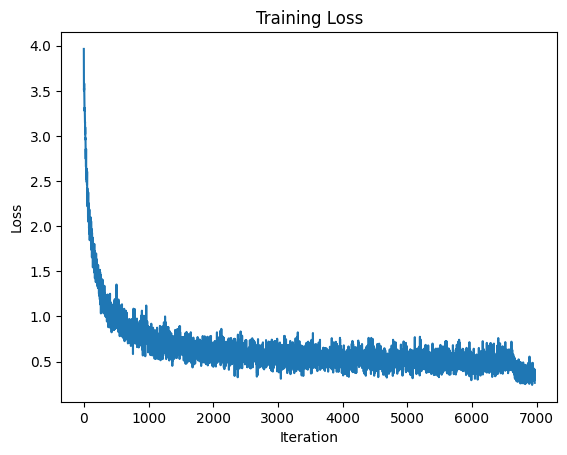

In [20]:
#21에포크일 경우
log_interval = 20
n_epoch = 21

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iterations.
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()  # Display the plot


# **Early Stopping**

Train Epoch: 1 [0/84843 (0%)]	Loss: 0.690555
Train Epoch: 1 [5120/84843 (6%)]	Loss: 0.651170
Train Epoch: 1 [10240/84843 (12%)]	Loss: 0.702488
Train Epoch: 1 [15360/84843 (18%)]	Loss: 0.611647
Train Epoch: 1 [20480/84843 (24%)]	Loss: 0.689110
Train Epoch: 1 [25600/84843 (30%)]	Loss: 0.585119
Train Epoch: 1 [30720/84843 (36%)]	Loss: 0.613899
Train Epoch: 1 [35840/84843 (42%)]	Loss: 0.554968
Train Epoch: 1 [40960/84843 (48%)]	Loss: 0.727414
Train Epoch: 1 [46080/84843 (54%)]	Loss: 0.669695
Train Epoch: 1 [51200/84843 (60%)]	Loss: 0.691935
Train Epoch: 1 [56320/84843 (66%)]	Loss: 0.713034
Train Epoch: 1 [61440/84843 (72%)]	Loss: 0.653106
Train Epoch: 1 [66560/84843 (78%)]	Loss: 0.718890
Train Epoch: 1 [71680/84843 (84%)]	Loss: 0.649557
Train Epoch: 1 [76800/84843 (90%)]	Loss: 0.736236
Train Epoch: 1 [81920/84843 (96%)]	Loss: 0.580697

Test Epoch: 1	Accuracy: 8404/11005 (76%)

Train Epoch: 2 [0/84843 (0%)]	Loss: 0.568565
Train Epoch: 2 [5120/84843 (6%)]	Loss: 0.456861
Train Epoch: 2 [10240

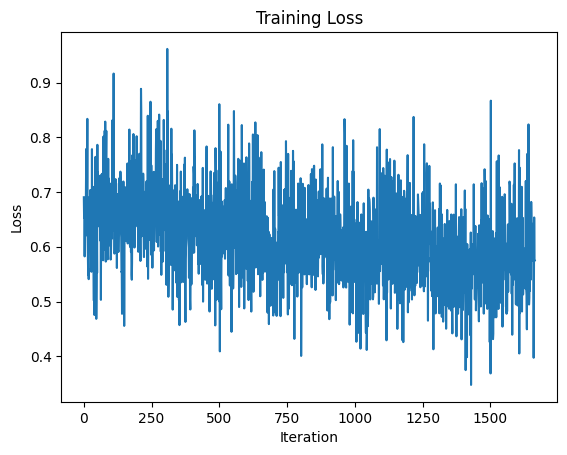

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

log_interval = 20
n_epoch = 21

patience = 5
best_val_loss = np.inf
counter = 0
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

transform = transform.to(device)

for epoch in range(1, n_epoch + 1):
    train_loss = train(model, epoch, log_interval)
    losses.append(train_loss)
    val_loss = test(model, epoch)

    if val_loss is not None and val_loss < best_val_loss:  # Check if val_loss is not None
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping after {epoch} epochs.")
        break

    scheduler.step()

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

Expected: zero. Predicted: zero.


Let’s find an example that isn’t classified correctly, if there is one.




In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
        break
else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

Data point #1. Expected: right. Predicted: nine.


Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




In [ ]:
import sys
sys.path


['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython']

In [ ]:
#ModuleNotFoundError: No module named 'pydub'문제 해결
#"pydub" 패키지의 경로가 경로 리스트에 없어서, 필요한 경로를 직접 추가
sys.path.append('/usr/local/lib/python3.8/site-packages')

In [ ]:
def record(seconds=3):

    from google.colab import output as colab_output
    from base64 import b64decode
    from io import BytesIO
    from pydub import AudioSegment

    RECORD = (
        b"const sleep  = time => new Promise(resolve => setTimeout(resolve, time))\n"
        b"const b2text = blob => new Promise(resolve => {\n"
        b"  const reader = new FileReader()\n"
        b"  reader.onloadend = e => resolve(e.srcElement.result)\n"
        b"  reader.readAsDataURL(blob)\n"
        b"})\n"
        b"var record = time => new Promise(async resolve => {\n"
        b"  stream = await navigator.mediaDevices.getUserMedia({ audio: true })\n"
        b"  recorder = new MediaRecorder(stream)\n"
        b"  chunks = []\n"
        b"  recorder.ondataavailable = e => chunks.push(e.data)\n"
        b"  recorder.start()\n"
        b"  await sleep(time)\n"
        b"  recorder.onstop = async ()=>{\n"
        b"    blob = new Blob(chunks)\n"
        b"    text = await b2text(blob)\n"
        b"    resolve(text)\n"
        b"  }\n"
        b"  recorder.stop()\n"
        b"})"
    )
    RECORD = RECORD.decode("ascii")

    print(f"Recording started for {seconds} seconds.")
    display(ipd.Javascript(RECORD))
    s = colab_output.eval_js("record(%d)" % (seconds * 1000))
    print("Recording ended.")
    b = b64decode(s.split(",")[1])

    fileformat = "wav"
    filename = f"_audio.{fileformat}"
    AudioSegment.from_file(BytesIO(b)).export(filename, format=fileformat)
    return torchaudio.load(filename)


# Detect whether notebook runs in google colab
if "google.colab" in sys.modules:
    waveform, sample_rate = record()
    print(f"Predicted: {predict(waveform)}.")
    ipd.Audio(waveform.numpy(), rate=sample_rate)

Recording started for 3 seconds.


<IPython.core.display.Javascript object>

Recording ended.
Predicted: go.


In [ ]:
ipd.Audio(transformed.numpy(), rate=new_sample_rate)

## Conclusion

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


